In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

In [2]:
#DATASET GENERATION ---
# Rationale: We generate a synthetic dataset because the problem space is
# mathematically defined (50x50 grid). 10,000 samples provide enough
# variance for the model to generalize across all possible (x,y) pairs.
def generate_dataset(num_samples=10000):
    """Generates 50x50 grayscale images with one white pixel."""
    images = np.zeros((num_samples, 50, 50, 1), dtype=np.float32)
    coords = np.zeros((num_samples, 2), dtype=np.float32)

    for i in range(num_samples):
        # Randomly pick coordinates
        x, y = np.random.randint(0, 50, size=2)
        images[i, x, y, 0] = 1.0  # Normalized 255 to 1.0 [cite: 4]
        coords[i] = [x, y]

    return images, coords

In [3]:
# Generate and split the data
X, y = generate_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- STEP 2: MODEL ARCHITECTURE ---
# Rationale: A CNN is used to extract spatial features. Since the image
# is sparse, we use two Conv layers followed by a Regression head.
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2)  # Output layer: 2 neurons for X and Y coordinates [cite: 3]
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [4]:
# --- STEP 3: TRAINING ---
print("Starting training...")
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Starting training...
Epoch 1/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 288.9193 - mae: 13.3642 - val_loss: 31.2018 - val_mae: 3.1361
Epoch 2/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 21.3393 - mae: 2.5976 - val_loss: 6.2735 - val_mae: 1.4314
Epoch 3/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 5.2307 - mae: 1.2879 - val_loss: 3.2749 - val_mae: 1.0396
Epoch 4/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - loss: 2.6753 - mae: 1.0003 - val_loss: 2.2421 - val_mae: 0.9143
Epoch 5/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - loss: 1.9739 - mae: 0.8172 - val_loss: 1.3712 - val_mae: 0.6736
Epoch 6/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 1.2137 - mae: 0.6717 - val_loss: 1.2840 - val_mae: 0.7793
Epoch 7/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 0.9678 - mae: 0.6228 - val_loss: 0.9335 - val_mae: 0.6739
Epoch 8/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.6923 - mae: 0.5593 - val_loss: 0.6068 - val_mae: 0.5273
Epoch 9/15
250

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


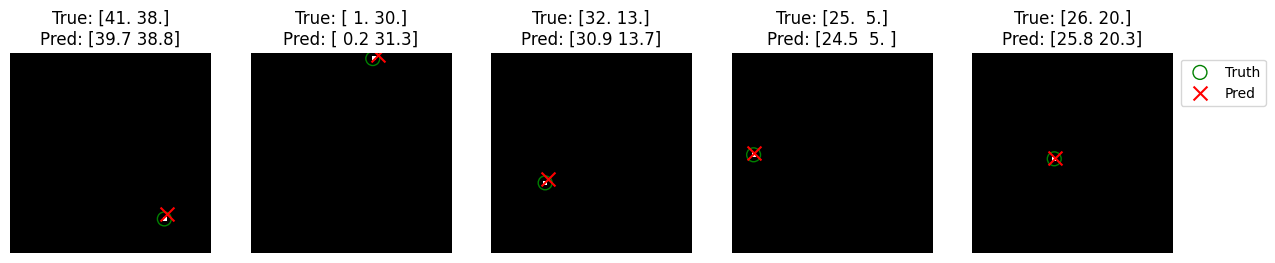

In [5]:
# --- STEP 4: VISUALIZATION & EVALUATION ---
def plot_results(X_val, y_val, model):
    """Plots Ground Truth vs Predicted coordinates."""
    preds = model.predict(X_val[:5])

    plt.figure(figsize=(15, 5))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_val[i].reshape(50, 50), cmap='gray')

        # Ground Truth (Green Circle)
        plt.scatter(y_val[i][1], y_val[i][0], s=100, edgecolors='g', facecolors='none', label='Truth')
        # Predicted (Red X)
        plt.scatter(preds[i][1], preds[i][0], marker='x', c='r', s=100, label='Pred')

        plt.title(f"True: {y_val[i]}\nPred: {np.round(preds[i], 1)}")
        plt.axis('off')
    plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
    plt.show()

plot_results(X_test, y_test, model)

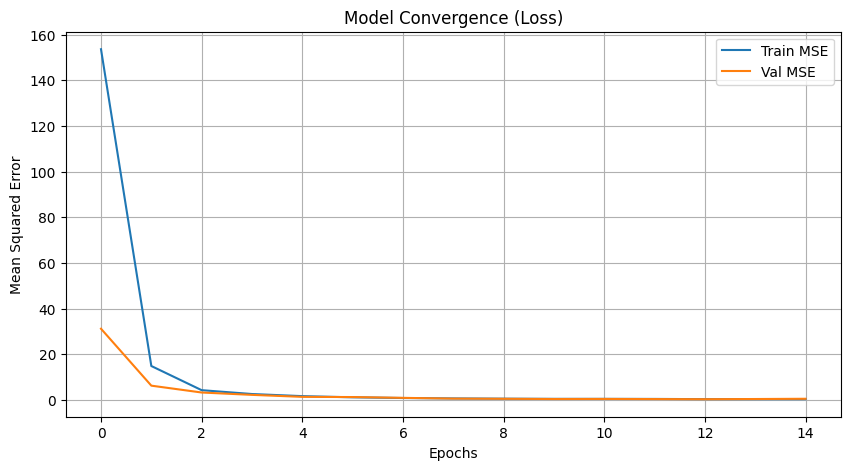

In [6]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Model Convergence (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def validate_input_image(image):
    """Checks if the input image follows the problem constraints."""
    if image.shape != (50, 50, 1):
        raise ValueError("Image must be 50x50 pixels.")
    if np.max(image) == 0:
        print("Warning: No white pixel (255) found in the image.")
    return True